In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpi
import json

from contrastive.utils.config import get_config_diff

In [2]:
path = "/neurospin/dico/agaudin/Runs/04_pointnet/Output/pointnet"
get_config_diff(path)

In [3]:
path = "/neurospin/dico/agaudin/Runs/04_pointnet/Output/pointnet"
_, config_diff = get_config_diff(path, save=False)
config_diff

,batch_size,drop_rate,foldlabel,lr,max_angle,num_outputs,num_representation_features,patch_size,temperature,temperature_initial
fold_30,16,0.15,True,0.0004,6,30,30,NaN,0.1,0.1
fold_30_(2),16,0.15,True,0.0004,6,30,30,NaN,0.1,0.1
fold_30_T=0.01,16,0.15,True,0.0004,6,30,30,NaN,0.01,0.01
fold_30_T=0.5,16,0.15,True,0.0004,6,30,30,NaN,0.5,0.5
fold_30_T=0.5_(2),16,0.15,True,0.0004,6,30,30,NaN,0.5,0.5
fold_30__batch_size=8e-4,8,0.15,True,0.0004,6,30,30,NaN,0.1,0.1
fold_30_drop_rate=0,16,0.0,True,0.0004,6,30,30,NaN,0.1,0.1
fold_30_drop_rate=0.05,16,0.05,True,0.0004,6,30,30,NaN,0.1,0.1
fold_30_drop_rate=0.1,16,0.1,True,0.0004,6,30,30,NaN,0.1,0.1
fold_30_drop_rate=0.3,16,0.3,True,0.0004,6,30,30,NaN,0.1,0.1


In [3]:
def exclude_conditions(diff_config, excluded_conditions):
    excluded_subdirs = []
    for cond in excluded_conditions:
        filtered_diff_config = diff_config.query(cond)
        excluded_subdirs.extend(filtered_diff_config['Unnamed: 0'].values)
    return excluded_subdirs

dir_path = "/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders/convnet/no_foldlabel_4"
diff_config = pd.read_csv(dir_path+'/config_diff.csv')

exclude_conditions(diff_config, excluded_conditions=["lr != 0.0004"])

['14-21-26']

In [4]:
def show_results(dir_path, figsize=(16,10), return_config_diff=False, excluded_conditions=[]):
    # be sure that all models are comparable
    get_config_diff(dir_path, whole_config=False)
    diff_config = pd.read_csv(dir_path+'/config_diff.csv')

    excluded_subdirs = exclude_conditions(diff_config, excluded_conditions)
    if excluded_conditions != []:
        print("Excluded subdirs :", excluded_subdirs)
        print("Excluded because of ", excluded_conditions)

    print(diff_config[~diff_config['Unnamed: 0'].isin(excluded_subdirs)])

    paths = []
    accuracy = []
    accuracy_std = []
    auc = []
    auc_std = []
    # plot all ROC curves
    for subdir in os.listdir(dir_path):
        if os.path.isdir(dir_path + '/' + subdir) and subdir not in excluded_subdirs:
            path = dir_path + '/' + subdir + '/cingulate_ACCpatterns_embeddings'
            with open(path+'/values.json', 'r') as file:
                values = json.load(file)
            print(subdir)
            print("AUC", values['cross_val_auc'])
            img = mpi.imread(path+'/cross_val_ROC_curves.png')
            plt.figure(figsize=figsize)
            plt.imshow(img)
            plt.show()

            # store the AUC and accuracy in a df
            paths.append(subdir)
            accuracy.append(values['cross_val_total_accuracy'][0])
            accuracy_std.append(values['cross_val_total_accuracy'][1])
            auc.append(values['cross_val_auc'][0])
            auc_std.append(values['cross_val_auc'][1])

    results_df = pd.DataFrame()
    results_df['path'] = paths
    results_df['auc'] = auc
    results_df['auc_std'] = auc_std
    results_df['accuracy'] = accuracy
    results_df['accuracy_std'] = accuracy_std


    if return_config_diff:
        return results_df, diff_config
    else:
        return results_df

                    Unnamed: 0  batch_size  drop_rate  foldlabel      lr  \
0                      fold_30          16       0.15       True  0.0004   
1                  fold_30_(2)          16       0.15       True  0.0004   
2               fold_30_T=0.01          16       0.15       True  0.0004   
3                fold_30_T=0.5          16       0.15       True  0.0004   
4            fold_30_T=0.5_(2)          16       0.15       True  0.0004   
5     fold_30__batch_size=8e-4           8       0.15       True  0.0004   
6          fold_30_drop_rate=0          16       0.00       True  0.0004   
7       fold_30_drop_rate=0.05          16       0.05       True  0.0004   
8   fold_30_drop_rate=0.05_(1)          16       0.05       True  0.0004   
9   fold_30_drop_rate=0.05_(2)          16       0.05       True  0.0004   
10  fold_30_drop_rate=0.05_(3)          16       0.05       True  0.0004   
11  fold_30_drop_rate=0.05_(5)          16       0.05       True  0.0004   
12       fol

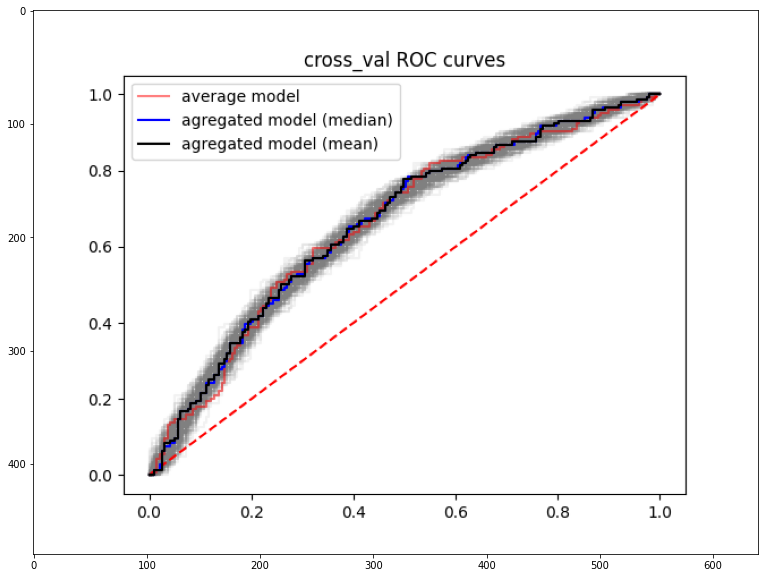

no_30_drop_rate=0
AUC [0.6515853073886068, 0.0012306939051254277]


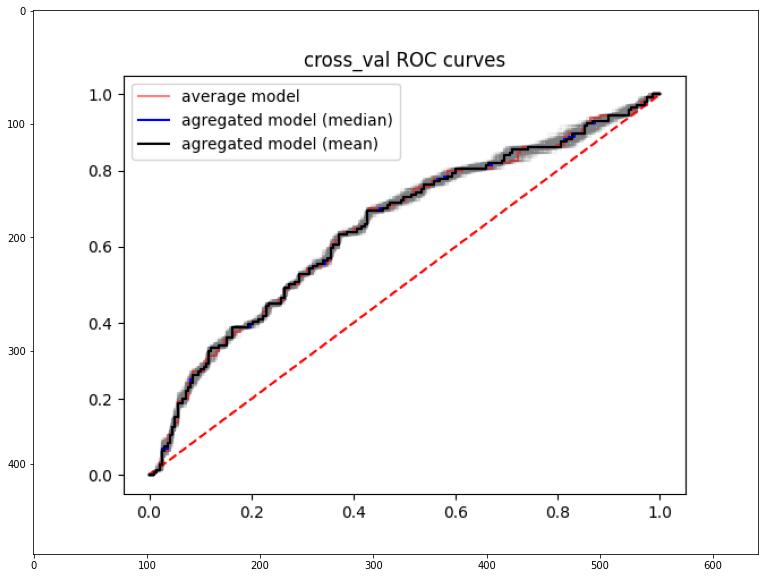

no_30_drop_rate_0.1
AUC [0.627033276931754, 0.018631637984641805]


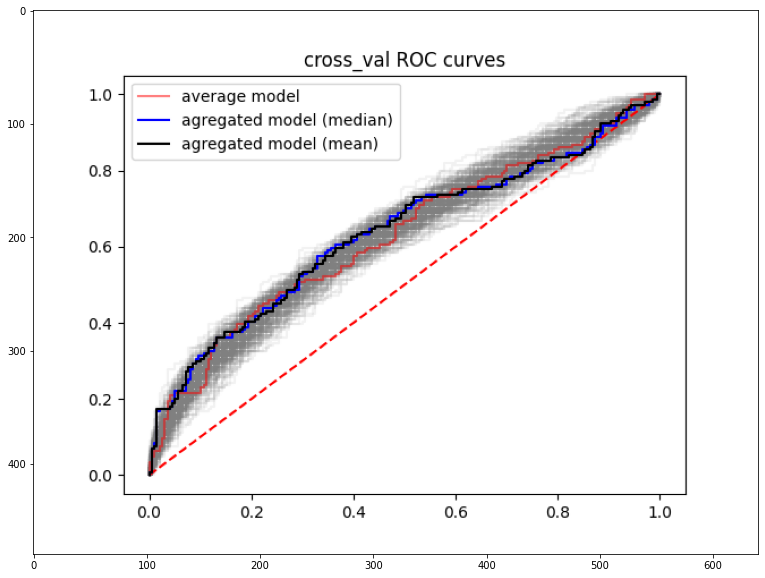

no_4_drop_rate=0.05
AUC [0.46336167512690357, 0.009882078723434724]


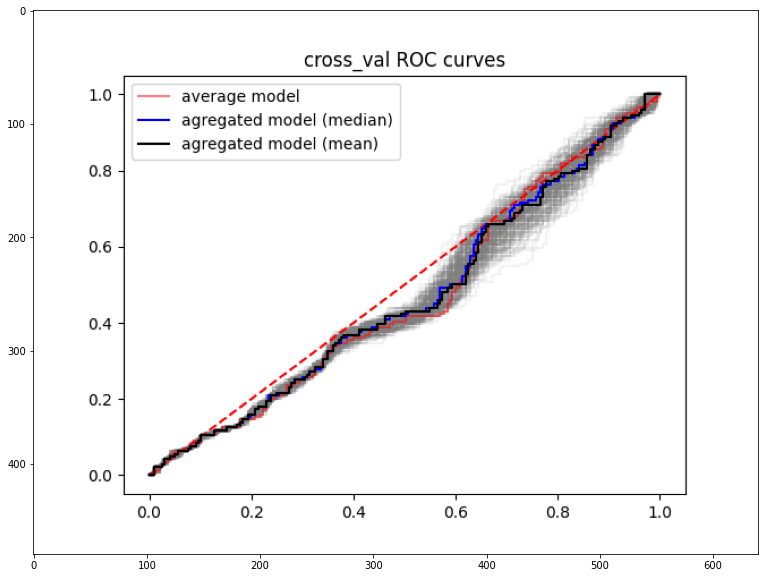

fold_4
AUC [0.5831160462492951, 0.036098478440895816]


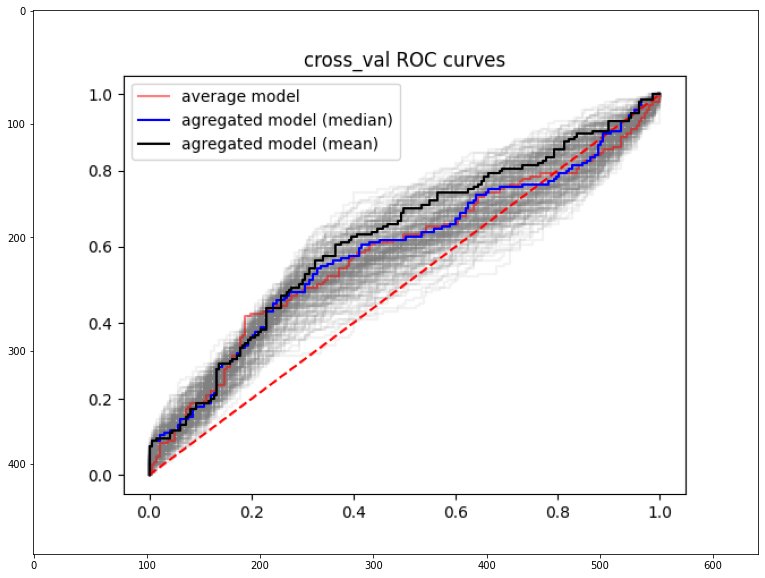

no_30
AUC [0.588038212069938, 0.032486653596675484]


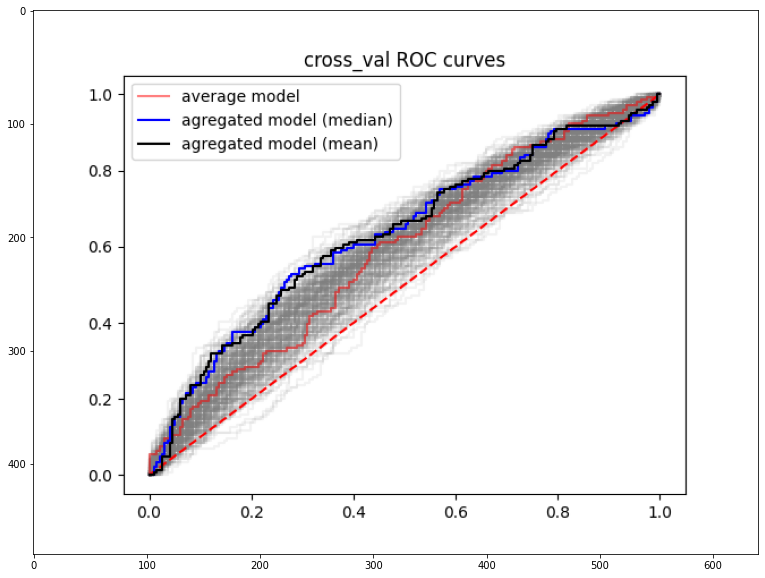

fold_30_drop_rate=0.3
AUC [0.5744959108855048, 0.0472764906375842]


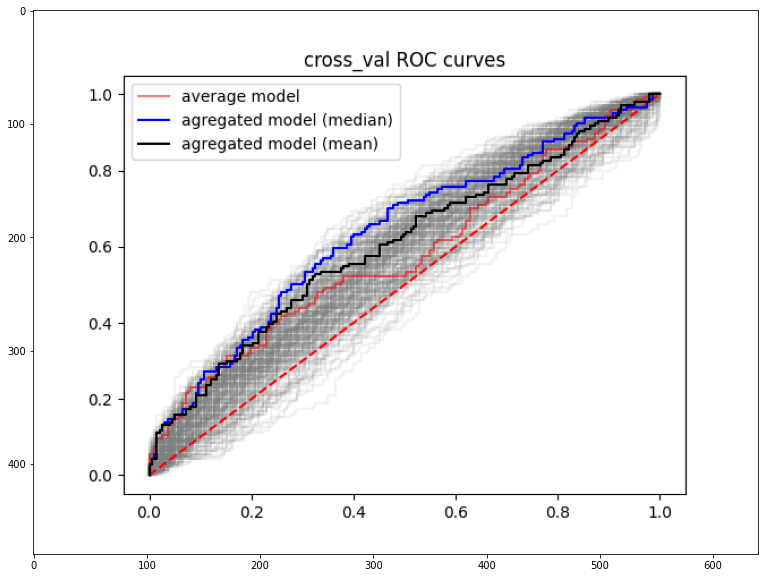

fold_30_T=0.5
AUC [0.694205301748449, 0.008691992877771046]


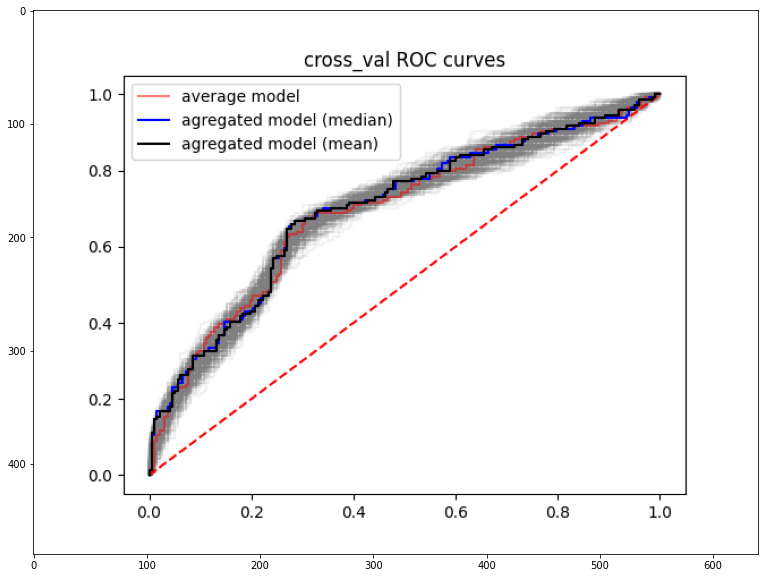

fold_30_drop_rate=0.05_(3)
AUC [0.6697773547659335, 0.00646225805945145]


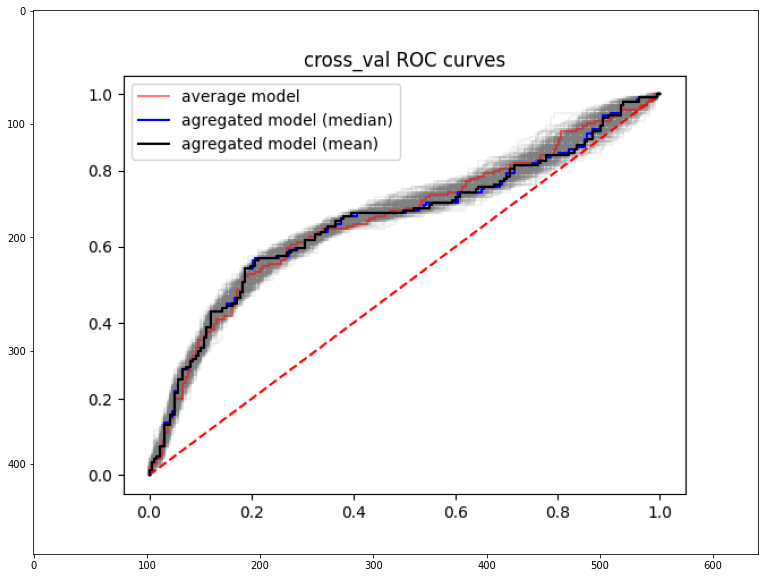

fold_30_drop_rate=0.1
AUC [0.6537893401015228, 0.010444870881689557]


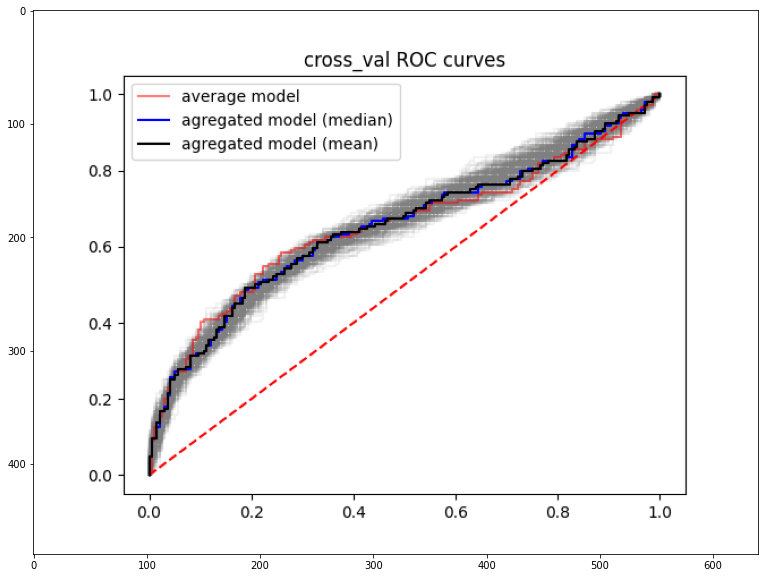

no_30_batch_size=8
AUC [0.5697844049633389, 0.02621574845757213]


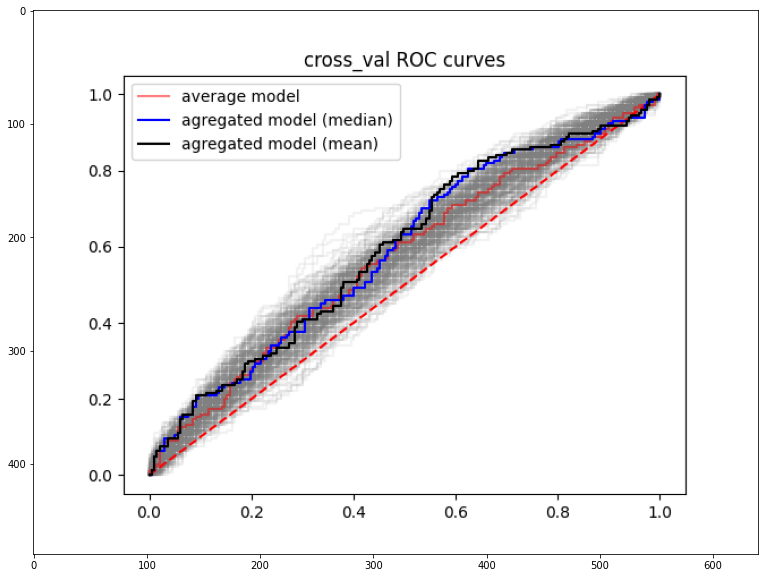

fold_30_drop_rate=0
AUC [0.6777129159616471, 0.0009471057914626203]


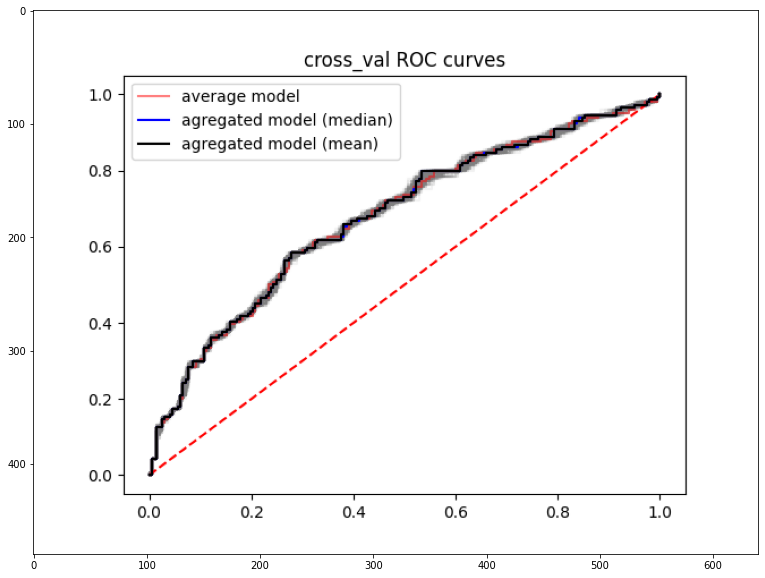

fold_30_T=0.5_(2)
AUC [0.6068907219402143, 0.01384591963475083]


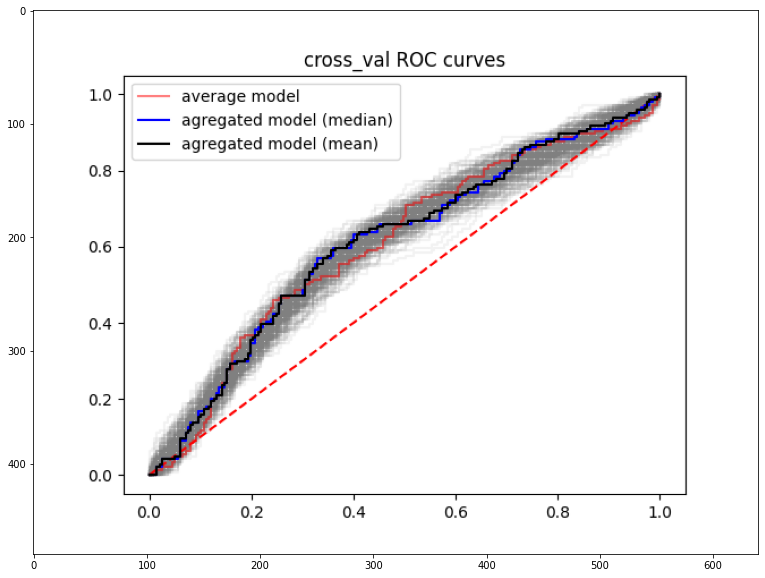

fold_30_lr=8e-4
AUC [0.6012987873660463, 0.04224189098069237]


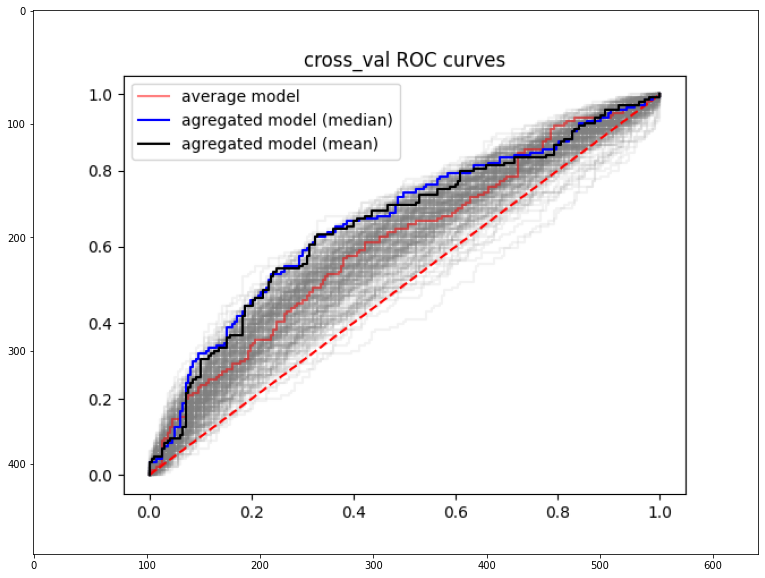

fold_30__batch_size=8e-4
AUC [0.5988993231810491, 0.01777059800126567]


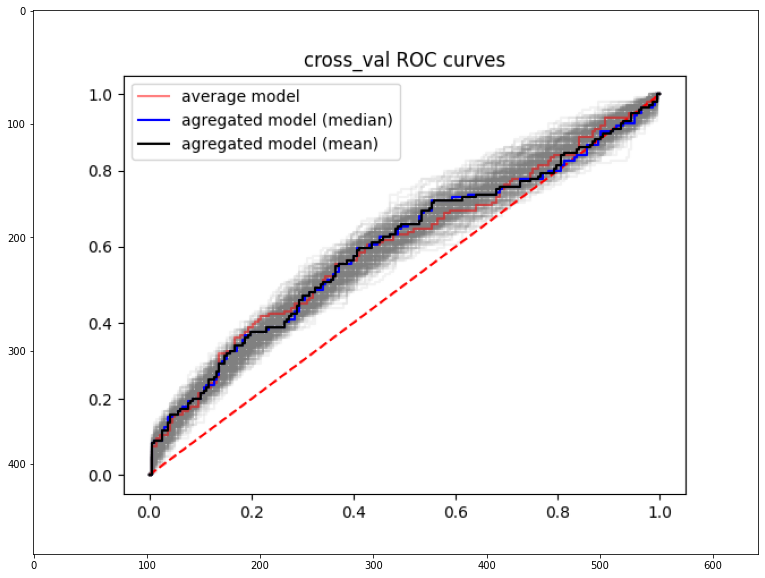

fold_30_drop_rate=0.05_(2)
AUC [0.6535455442752398, 0.0060334001474754585]


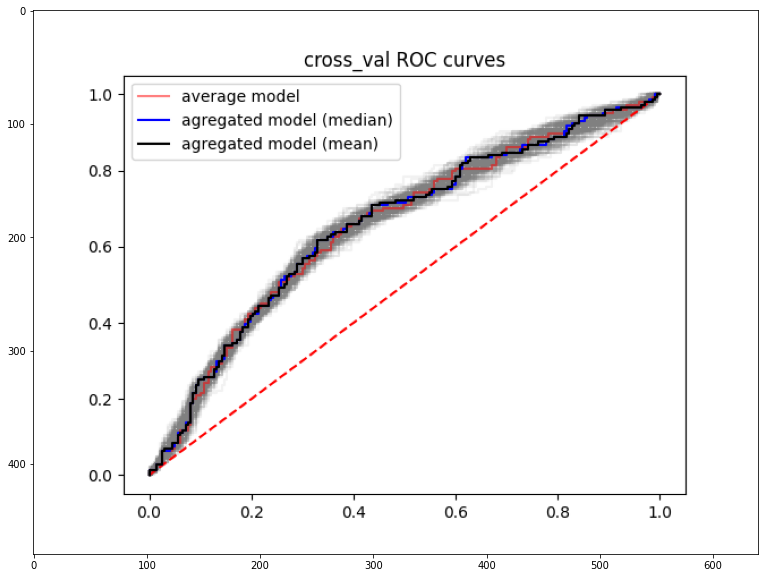

fold_30_drop_rate=0.05_(1)
AUC [0.6674885786802031, 0.0072576486867747215]


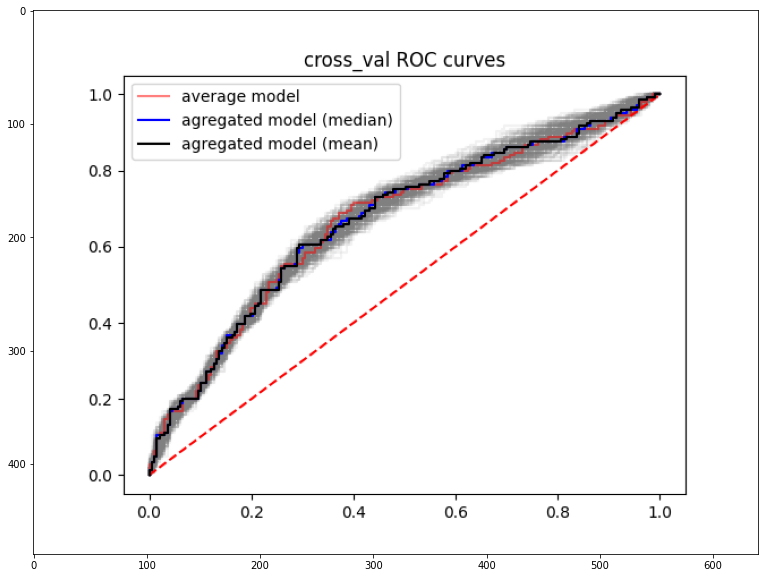

no_4
AUC [0.4868723914269599, 0.025557562880392383]


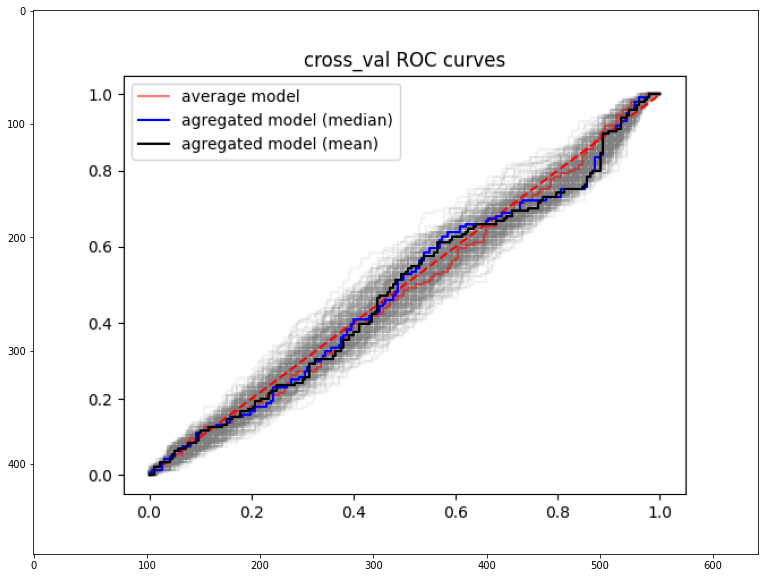

fold_4_lr=8e-4
AUC [0.6586566553863509, 0.007874074449958225]


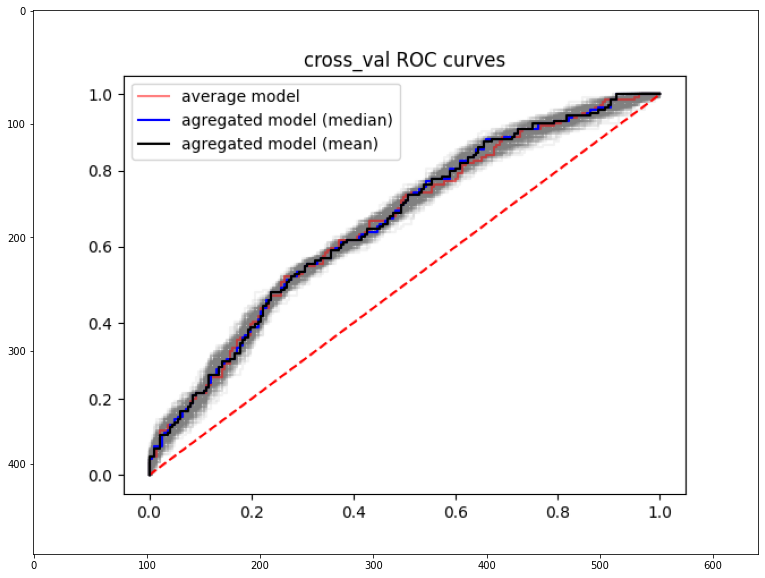

fold_30_T=0.01
AUC [0.6389568527918781, 0.012381237992257038]


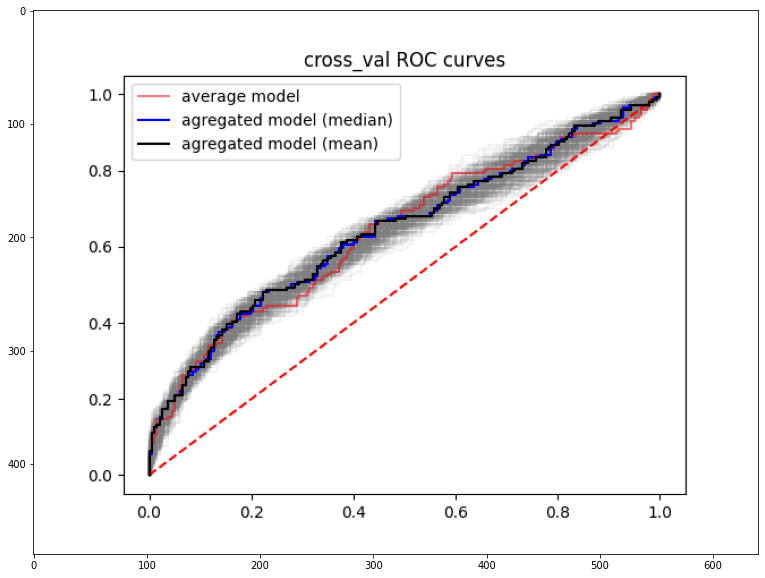

fold_30
AUC [0.6748970671178792, 0.015476280527482112]


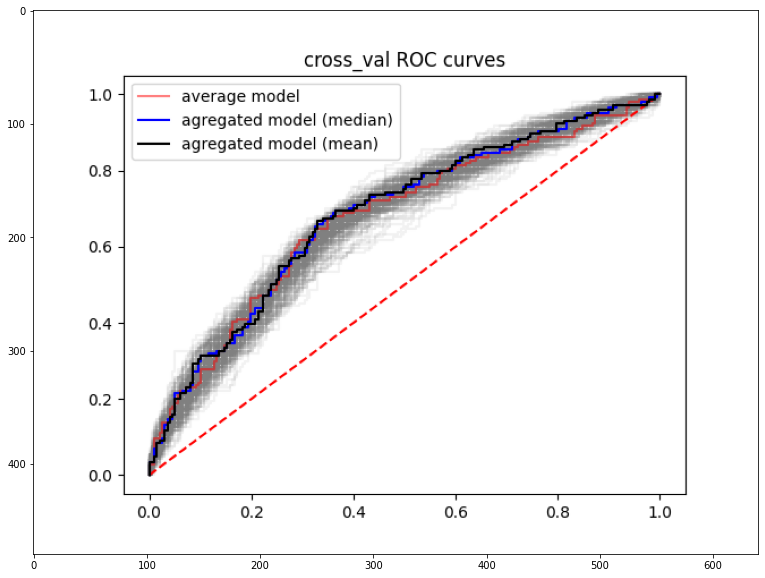

fold_30_(2)
AUC [0.6682361816130852, 0.01853822620539792]


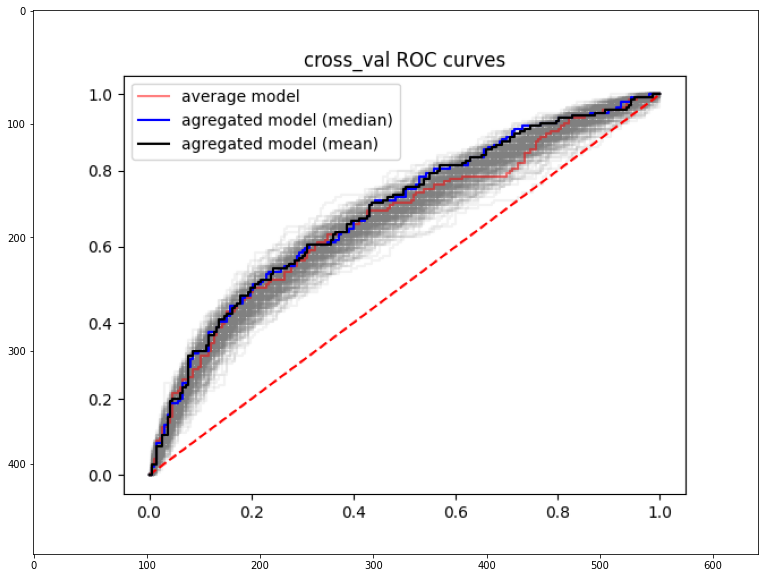

no_30_(2)
AUC [0.6141456570783983, 0.015697358684503185]


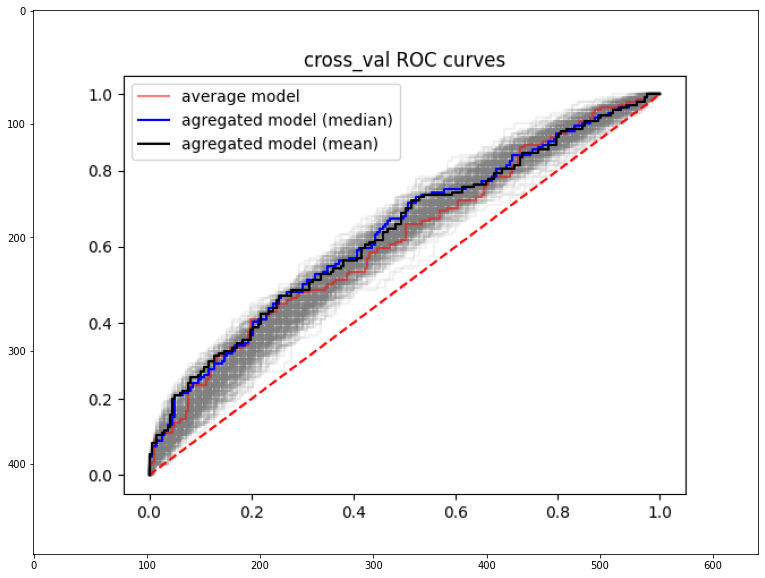

fold_30_drop_rate=0.05_(5)
AUC [0.666463056965595, 0.007005521681139295]


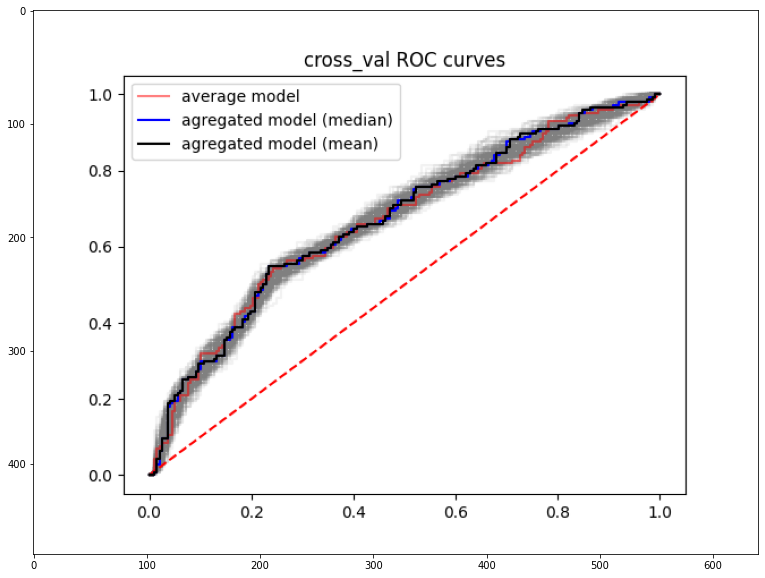

fold_30_drop_rate=0.05
AUC [0.6700785391990975, 0.00825907614470367]


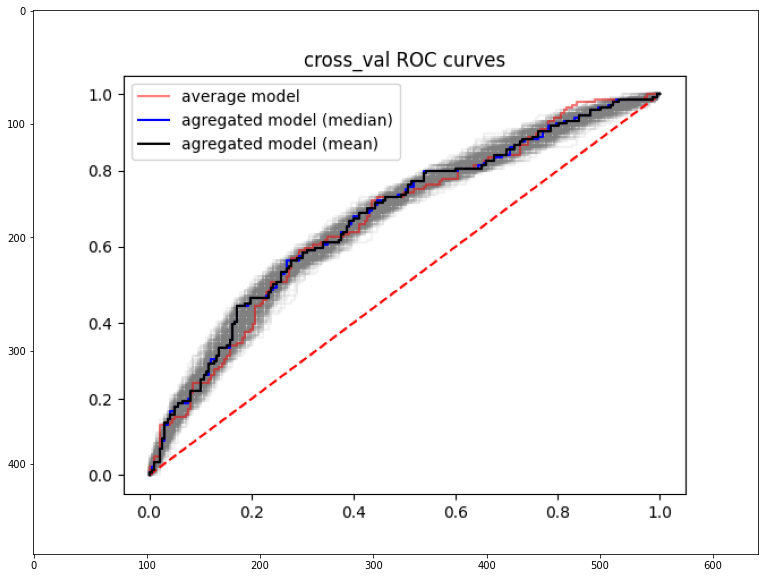

,path,auc,auc_std,accuracy,accuracy_std
0,no_30_drop_rate=0.05,0.659243,0.006187,0.631214,0.009741
1,no_30_drop_rate=0,0.651585,0.001231,0.622804,0.002003
2,no_30_drop_rate_0.1,0.627033,0.018632,0.625161,0.012915
3,no_4_drop_rate=0.05,0.463362,0.009882,0.559331,0.002454
4,fold_4,0.583116,0.036098,0.598018,0.014142
5,no_30,0.588038,0.032487,0.583425,0.027912
6,fold_30_drop_rate=0.3,0.574496,0.047276,0.567390,0.038094
7,fold_30_T=0.5,0.694205,0.008692,0.669267,0.009264
8,fold_30_drop_rate=0.05_(3),0.669777,0.006462,0.680352,0.007750
9,fold_30_drop_rate=0.1,0.653789,0.010445,0.661196,0.009620


In [6]:
excluded_conditions = []

results_df = show_results("/neurospin/dico/agaudin/Runs/04_pointnet/Output/pointnet",
excluded_conditions=excluded_conditions)

results_df

In [7]:
results_df.sort_values(ascending=False, by='auc')[['path', 'auc']]

,path,auc
7,fold_30_T=0.5,0.694205
11,fold_30_drop_rate=0,0.677713
20,fold_30,0.674897
24,fold_30_drop_rate=0.05,0.670079
8,fold_30_drop_rate=0.05_(3),0.669777
21,fold_30_(2),0.668236
16,fold_30_drop_rate=0.05_(1),0.667489
23,fold_30_drop_rate=0.05_(5),0.666463
0,no_30_drop_rate=0.05,0.659243
18,fold_4_lr=8e-4,0.658657


In [ ]:
excluded_conditions = []

results_df = show_results("/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders/supervised/acc/aymeric",
excluded_conditions=excluded_conditions)

results_df

In [22]:
results_df.sort_values(ascending=False, by='auc')[['path', 'auc']]

,path,auc
2,lr=0.0008,0.564815
1,non_supervised_lr=0.0008,0.555703
0,lr=0.0004,0.532388


In [ ]:
# convnet exploration
excluded_conditions = []

results_df = show_results("/neurospin/dico/agaudin/Runs/03_monkeys/Output/convnet_exploration",
excluded_conditions=excluded_conditions)

results_df

In [8]:
results_df.sort_values(ascending=False, by='auc')[['path', 'auc']]

,path,auc
11,base1,0.673959
2,T_1,0.655674
10,drop_rate_0,0.654164
9,base2,0.648114
14,base3,0.644770
5,batch_size_64,0.636690
8,T_0.01,0.626335
4,T_0.5,0.624267
7,batch_size_4,0.617623
3,drop_rate_0.3,0.609882


In [11]:
# directories are supposed to have a certain structure and name patterns
def get_results_table(dir_path, model_types=['convnet', 'densenet2'], verbose=False):
    results = {k: {} for k in model_types}

    for model_type in os.listdir(dir_path):
        if model_type in model_types:
            if verbose:
                print(model_type)
            path = os.path.join(dir_path, model_type)
            for params in os.listdir(path):
                params_path = os.path.join(path, params)
                if os.path.isdir(params_path):
                    if verbose:
                        print(params)
                    
                    n_models = 0

                    if model_type == 'pca':
                        results[model_type]['foldlabel_'+params] = 0
                        results[model_type]['no_foldlabel_'+params] = 0
                    else:    
                        results[model_type][params] = 0
                    
                    for model in os.listdir(params_path):
                        model_path = os.path.join(params_path, model)
                        # start a model name by & to filter it out of the performance analysis
                        if os.path.isdir(model_path) and model[0] != '&':
                            if verbose:
                                print(model)

                            n_models += 1

                            if model_type == 'pca':
                                values = os.path.join(params_path, model, 'values.json')
                                with open(values, 'r') as file:
                                    values = json.load(file)
                                results[model_type]['foldlabel_'+params] += values['cross_val_auc'][0]
                                results[model_type]['no_foldlabel_'+params] += values['cross_val_auc'][0]
                            else:
                                values = os.path.join(params_path, model, 'cingulate_ACCpatterns_embeddings/values.json')
                                with open(values, 'r') as file:
                                    values = json.load(file)
                                results[model_type][params] += values['cross_val_auc'][0]
                    
                    if model_type == 'pca':
                        results[model_type]['foldlabel_'+params] = results[model_type]['foldlabel_'+params]/n_models
                        results[model_type]['no_foldlabel_'+params] = results[model_type]['no_foldlabel_'+params]/n_models
                    else:
                        results[model_type][params] = results[model_type][params]/n_models
    
    results_df = pd.DataFrame(results)
    results_df.sort_index(inplace=True)
    return results_df

In [12]:
dir_path = "/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders"
results_df = get_results_table(dir_path, model_types=['convnet', 'densenet2', 'pca'])

results_df.to_csv("/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders/performance_comparison_5000.csv")

results_df

,convnet,densenet2,pca
foldlabel_30,0.613729,0.658608,0.593625
foldlabel_4,0.589703,0.574395,0.538784
no_foldlabel_30,0.649748,0.575910,0.593625
no_foldlabel_4,0.514435,0.488433,0.538784


## Use the database

In [60]:
bdd = pd.read_csv("/neurospin/dico/agaudin/Runs/new_bdd_models.csv", index_col=0)
bdd

,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,...,max_angle,max_epochs,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,dataset_name,git_branch
0,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.595940,0.045925,0.575977,0.035288,convnet,16,0.15,100,True,...,6,250,30,30,0.1,0.1,0.349243,0.515141,cingulate_HCP_half_1,Run_03_aymeric
1,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.600870,0.040834,0.578182,0.038861,convnet,16,0.15,100,True,...,6,250,30,30,0.1,0.1,0.376334,0.615989,cingulate_HCP_half_1,Run_03_aymeric
2,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.659754,0.048348,0.617584,0.042720,convnet,16,0.15,250,True,...,6,250,30,30,0.1,0.1,0.416473,0.440377,cingulate_HCP_half_1,Run_03_aymeric
3,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.605214,0.042651,0.588129,0.037000,convnet,16,0.15,100,True,...,6,250,30,30,0.1,0.1,0.392093,0.608668,cingulate_HCP_half_1,Run_03_aymeric
4,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.606865,0.044687,0.588305,0.037069,convnet,16,0.15,250,True,...,6,250,30,30,0.1,0.1,0.330082,0.690635,cingulate_HCP_half_1,Run_03_aymeric
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.651585,0.001231,0.622804,0.002003,pointnet,16,0.00,100,False,...,10,250,30,30,0.1,0.1,0.890107,0.724653,cingulate_HCP_half_1,pointnet
105,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.659243,0.006187,0.631214,0.009741,pointnet,16,0.05,100,False,...,10,250,30,30,0.1,0.1,1.053026,1.015665,cingulate_HCP_half_1,pointnet
106,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.627033,0.018632,0.625161,0.012915,pointnet,16,0.10,100,False,...,10,250,30,30,0.1,0.1,1.952606,1.368340,cingulate_HCP_half_1,pointnet
107,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.486872,0.025558,0.577713,0.000000,pointnet,16,0.15,100,False,...,10,250,4,4,0.1,0.1,4.179968,3.784941,cingulate_HCP_half_1,pointnet


In [61]:
bdd.sort_values(by='auc', ascending=False, inplace=True)

interesting_columns = ["model_path", 'auc', 'auc_std', 'backbone_name', 'batch_size', 'dataset_name', 'drop_rate', 'foldlabel',
                       'num_representation_features', 'temperature']
bdd[interesting_columns].iloc[:10,:]

,model_path,auc,auc_std,backbone_name,batch_size,dataset_name,drop_rate,foldlabel,num_representation_features,temperature
81,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.694205,0.008692,pointnet,16,cingulate_HCP_half_1,0.15,True,30,0.5
25,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.692153,0.049598,densenet,16,cingulate_HCP_half_1,0.15,True,30,0.1
89,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.678702,0.006920,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.1
12,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.678640,0.044072,convnet,16,cingulate_HCP_half_1,0.15,False,30,0.1
84,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.677713,0.000947,pointnet,16,cingulate_HCP_half_1,0.00,True,30,0.1
78,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.674897,0.015476,pointnet,16,cingulate_HCP_half_1,0.15,True,30,0.1
50,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.673959,0.041645,convnet,16,cingulate_HCP_half_1,0.15,False,30,0.1
70,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.672935,0.013104,pointnet,16,cingulate_HCP_full,0.05,True,4,0.5
85,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.670079,0.008259,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.1
88,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.669777,0.006462,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.1


convnet, N = 39, mean performance: 0.595888285102752
densenet, N = 23, mean performance: 0.5642451139066678
pointnet, N = 41, mean performance: 0.6196921539900678


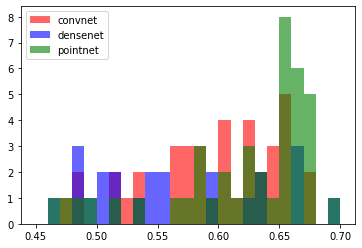

In [62]:
# compare backbones
backbones = ['convnet', 'densenet', 'pointnet']
colors = ['r', 'b', 'g']

plt.figure()

bins = np.arange(0.45, 0.71, step=0.01)

for i,backbone in enumerate(backbones):
    filtered_bdd = bdd[(bdd.backbone_name == backbone) & ~(bdd.model_path.str.contains('unfinished'))]
    print(f"{backbone}, N = {filtered_bdd.shape[0]}, mean performance: {filtered_bdd.auc.mean()}")
    plt.hist(filtered_bdd['auc'].values, bins, color=colors[i], alpha=0.6)

plt.legend(backbones)
plt.show()

/!\ AUX FACTEURS DE CONFUSION, FOLDLABEL PLUS ASSOCIÉ AUX BONS BACKBONES ?
False, N = 52, mean performance: 0.5705982499240748
True, N = 57, mean performance: 0.6183623999366717


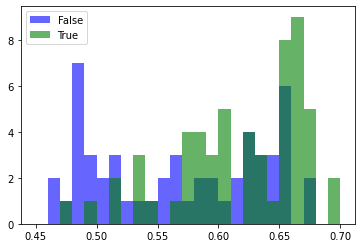

In [63]:
# compare augmentations

foldlabels = [False, True]
colors = ['b', 'g']

print("/!\ AUX FACTEURS DE CONFUSION, FOLDLABEL PLUS ASSOCIÉ AUX BONS BACKBONES ?")

plt.figure()

bins = np.arange(0.45, 0.71, step=0.01)

for i,foldlabel in enumerate(foldlabels):
    filtered_bdd = bdd[bdd.foldlabel == foldlabel]
    print(f"{foldlabel}, N = {filtered_bdd.shape[0]}, mean performance: {filtered_bdd.auc.mean()}")
    plt.hist(filtered_bdd['auc'].values, bins, color=colors[i], alpha=0.6)

plt.legend(foldlabels)
plt.show()

In [64]:
backbones = ['convnet', 'densenet', 'pointnet']
foldlabels = [False, True]

df = pd.DataFrame(np.zeros((3,2)), columns=foldlabels, index=backbones)

for i,backbone in enumerate(backbones):
    for j,foldlabel in enumerate(foldlabels):
        filtered_bdd = bdd[(bdd.backbone_name == backbone) & (bdd.foldlabel == foldlabel)]
        df[foldlabel][backbone] = filtered_bdd.auc.mean()

df

,False,True
convnet,0.595376,0.596913
densenet,0.524048,0.616502
pointnet,0.582508,0.628706


4, N = 42, mean performance: 0.5524587798458357
30, N = 65, mean performance: 0.6253540283743328


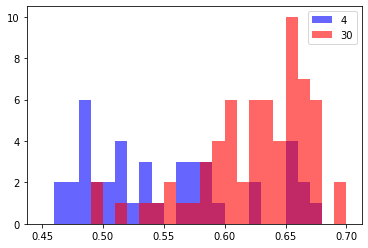

In [77]:
dimensions = [4, 30]
colors = ['b', 'r']

for i,dim in enumerate(dimensions):
    filtered_bdd = bdd[bdd.num_representation_features == dim]
    print(f"{dim}, N = {filtered_bdd.shape[0]}, mean performance: {filtered_bdd.auc.mean()}")
    plt.hist(filtered_bdd['auc'].values, bins, color=colors[i], alpha=0.6)

plt.legend(dimensions)
plt.show()

In [67]:
pointnets = bdd[(bdd.backbone_name == 'pointnet')]
pointnets = pointnets[interesting_columns]
pointnets

,model_path,auc,auc_std,backbone_name,batch_size,dataset_name,drop_rate,foldlabel,num_representation_features,temperature
81,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.694205,0.008692,pointnet,16,cingulate_HCP_half_1,0.15,True,30,0.50
89,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.678702,0.006920,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.10
84,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.677713,0.000947,pointnet,16,cingulate_HCP_half_1,0.00,True,30,0.10
78,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.674897,0.015476,pointnet,16,cingulate_HCP_half_1,0.15,True,30,0.10
70,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.672935,0.013104,pointnet,16,cingulate_HCP_full,0.05,True,4,0.50
85,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.670079,0.008259,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.10
88,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.669777,0.006462,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.10
79,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.668236,0.018538,pointnet,16,cingulate_HCP_half_1,0.15,True,30,0.10
86,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.667489,0.007258,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.10
90,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.666463,0.007006,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.10


In [68]:
comp_df = pointnets[(pointnets.foldlabel == True) & (pointnets.drop_rate == 0.05)]

print("Half hcp:", comp_df[comp_df.dataset_name == "cingulate_HCP_half_1"].auc.mean())
print("Full hcp:", comp_df[comp_df.dataset_name == "cingulate_HCP_full"].auc.mean())

comp_df

Half hcp: 0.6330166641029585
Full hcp: 0.6152975606316977


,model_path,auc,auc_std,backbone_name,batch_size,dataset_name,drop_rate,foldlabel,num_representation_features,temperature
89,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.678702,0.006920,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.1
70,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.672935,0.013104,pointnet,16,cingulate_HCP_full,0.05,True,4,0.5
85,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.670079,0.008259,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.1
88,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.669777,0.006462,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.1
86,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.667489,0.007258,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.1
90,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.666463,0.007006,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.1
73,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.661953,0.003243,pointnet,16,cingulate_HCP_half_1,0.05,True,4,0.5
93,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.661557,0.011752,pointnet,16,cingulate_HCP_full,0.05,True,30,0.1
69,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.659615,0.005971,pointnet,16,cingulate_HCP_full,0.05,True,4,0.5
94,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.654295,0.010130,pointnet,16,cingulate_HCP_full,0.05,True,30,0.1


In [67]:
bdd[(bdd.backbone_name == 'densenet') & (bdd.num_representation_features == 4)][['auc', 'foldlabel']]

,auc,foldlabel
31,0.667760,True
28,0.598181,True
27,0.547569,True
30,0.538566,True
29,0.519898,True
37,0.507891,False
40,0.501068,False
41,0.483937,False
39,0.482994,False
38,0.466274,False


In [54]:
# consistency analysis
# take models with the same parameters and compare the performance

params = ['backbone_name', 'batch_size', 'drop_rate', 'early_stopping_patience',
        'foldlabel', 'input_size', 'lr', 'max_angle', 'max_epochs',
        'num_outputs', 'num_representation_features', 'numpy_all',
        'temperature', 'temperature_initial', 'git_branch']

df = bdd[params]

bdd[df.duplicated(keep=False) & (bdd.backbone_name == 'pointnet')]


,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,input_size,lr,max_angle,max_epochs,num_outputs,num_representation_features,numpy_all,temperature,temperature_initial,git_branch
71,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.694205,0.008692,0.669267,0.009264,pointnet,16,0.15,100,True,"(1, 17, 40, 38)",0.0004,6,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.5,0.5,pointnet
68,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.674897,0.015476,0.641771,0.015699,pointnet,16,0.15,100,True,"(1, 17, 40, 38)",0.0004,6,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.1,0.1,pointnet
69,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.668236,0.018538,0.655707,0.015699,pointnet,16,0.15,100,True,"(1, 17, 40, 38)",0.0004,6,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.1,0.1,pointnet
82,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.614146,0.015697,0.604997,0.017516,pointnet,16,0.15,100,False,"(1, 17, 40, 38)",0.0004,10,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.1,0.1,pointnet
72,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.606891,0.013846,0.607930,0.012928,pointnet,16,0.15,100,True,"(1, 17, 40, 38)",0.0004,6,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.5,0.5,pointnet
81,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.588038,0.032487,0.583425,0.027912,pointnet,16,0.15,100,False,"(1, 17, 40, 38)",0.0004,10,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.1,0.1,pointnet


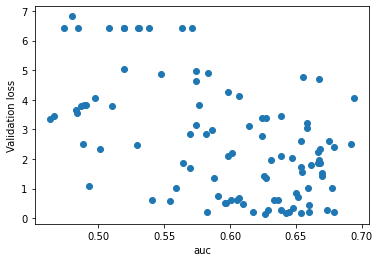

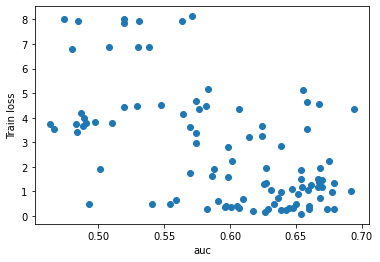

In [59]:
plt.scatter(bdd.auc, bdd.val_loss)
plt.xlabel('auc')
plt.ylabel('Validation loss')

plt.figure()
plt.scatter(bdd.auc, bdd.train_loss)
plt.xlabel('auc')
plt.ylabel('Train loss')

plt.show()

In [76]:
bad_models = bdd[bdd.auc <= 0.55]

print("proportion 4 parmi les mauvais modèles :", bad_models[bad_models.num_representation_features == 4].shape[0]/bad_models.shape[0])
print("proportion 4 parmi les modèles :", bdd[bdd.num_representation_features == 4].shape[0]/bdd.shape[0])

bad_models

proportion 4 parmi les mauvais modèles : 0.7931034482758621
proportion 4 parmi les modèles : 0.3853211009174312


,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,...,max_angle,max_epochs,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,dataset_name,git_branch
27,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.547569,0.057362,0.539683,0.044184,densenet,16,0.15,100,True,...,6,250,4,4,0.1,0.1,4.531240,4.867878,cingulate_HCP_half_1,Run_03_aymeric
34,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.540923,0.033724,0.539085,0.029719,densenet,16,0.15,100,False,...,10,250,30,30,0.1,0.1,0.491312,0.603156,cingulate_HCP_half_1,Run_03_aymeric
30,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.538566,0.027027,0.577713,0.000000,densenet,16,0.15,100,True,...,6,250,4,4,0.1,0.1,6.863671,6.433455,cingulate_HCP_half_1,Run_03_aymeric
76,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.536983,0.005141,0.544880,0.003870,pointnet,16,0.05,100,True,...,6,250,4,4,0.5,0.5,4.673968,4.301939,cingulate_HCP_half_1,pointnet
8,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.530707,0.044796,0.506229,0.049234,convnet,16,0.15,250,True,...,6,250,4,4,0.1,0.1,7.934582,6.433455,cingulate_HCP_half_1,Run_03_aymeric
57,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.530619,0.044917,0.518217,0.051808,convnet,16,0.60,100,False,...,10,250,30,30,0.1,0.1,6.863864,6.437438,cingulate_HCP_half_1,Run_03_aymeric
21,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.529559,0.046242,0.530170,0.036701,convnet,16,0.15,250,False,...,10,250,4,4,0.1,0.1,4.490583,2.484959,cingulate_HCP_half_1,Run_03_aymeric
29,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.519898,0.052222,0.517889,0.044333,densenet,16,0.15,100,True,...,6,250,4,4,0.1,0.1,4.442244,5.053896,cingulate_HCP_half_1,Run_03_aymeric
18,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.519531,0.036233,0.508657,0.047433,convnet,16,0.15,100,False,...,10,250,4,4,0.1,0.1,8.032898,6.433870,cingulate_HCP_half_1,Run_03_aymeric
16,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.519293,0.042167,0.507683,0.046822,convnet,16,0.15,100,False,...,10,250,4,4,0.1,0.1,7.847290,6.433280,cingulate_HCP_half_1,Run_03_aymeric


### Compare full HCP and half HCP

In [84]:
# first batch

hcp_full = bdd[(bdd.dataset_name == 'cingulate_HCP_full') & (bdd.num_representation_features == 30)]
hcp_half = bdd[(bdd.dataset_name != 'cingulate_HCP_full') & (bdd.num_representation_features == 30) & (bdd.drop_rate == 0.05) & (bdd.foldlabel == True)]

print("Full:", hcp_full.auc.mean(), "Half:", hcp_half.auc.mean())

Full: 0.6439337281443881 Half: 0.6676759259259258


In [85]:
# second batch

hcp_full = bdd[(bdd.dataset_name == 'cingulate_HCP_full') & (bdd.num_representation_features == 4)]
hcp_half = bdd[(bdd.dataset_name != 'cingulate_HCP_full') & (bdd.num_representation_features == 4) & (bdd.drop_rate == 0.05) & (bdd.foldlabel == True)]

print("Full:", hcp_full.auc.mean(), "Half:", hcp_half.auc.mean())

Full: 0.5866613931190072 Half: 0.5914255499153975


Full HCP isn't worth it